<a href="https://colab.research.google.com/github/yubin0727/captcha_recognition/blob/main/Captcha_model_character_traindata_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# gpu 사용
!nvidia-smi

Sun Dec 18 05:27:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    27W /  70W |   7546MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import cv2
from glob import glob
from google.colab.patches import cv2_imshow
import numpy as np

np.random.seed(42)

# 데이터를 불러오고 이미지 개수를 출력
data_list = glob('sample_data/samples/*.png')
len_data = len(data_list)
print(len(data_list))

1040


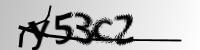

In [ ]:
# 샘플 이미지 출력
img = cv2.imread(data_list[0], cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

In [ ]:
def data_augmentation(image,data_height = 50,data_width = 200,n_channel = 1):
  image1 = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0) # 뒷배경을 제거
  image2 = cv2.morphologyEx(image, cv2.MORPH_CLOSE, np.ones((4,1), np.uint8))
  image3 = cv2.morphologyEx(image1, cv2.MORPH_CLOSE, np.ones((4,1), np.uint8))

  image  = np.reshape(image, (data_height, data_width, n_channel)) / 255   # 모델 학습을 위해 0 - 1 사이의 값으로 스케일링
  image1 = np.reshape(image1, (data_height, data_width, n_channel)) / 255   
  image2 = np.reshape(image2, (data_height, data_width, n_channel)) / 255   
  image3 = np.reshape(image3, (data_height, data_width, n_channel)) / 255  
  return image, image1, image2, image3

In [ ]:
def preprocess_image(image,data_height = 50,data_width = 200,n_channel = 1):
  image = np.reshape(image, (data_height, data_width, n_channel)) / 255   # 모델 학습을 위해 0 - 1 사이의 값으로 스케일링
  return image

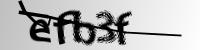

['e' 'f' 'b' '3' 'f']


In [ ]:
# 이미지 크기, 채널
data_height = 50
data_width = 200
n_channel = 1

images = np.zeros((len_data, data_height, data_width, n_channel))
label = np.empty((len_data, 5), dtype = str)
characters = []

# 이미지 전처리와 글자 파싱
for n, path in enumerate(data_list):
  image = cv2.imread(data_list[n], cv2.IMREAD_GRAYSCALE)
  image = preprocess_image(image)
  images[n, :, :, :] = image
  path = list(path.split('/')[2].split('.')[0])
  label[n] = np.array(path)
  for i in range(5):
    characters.append(path[i])

cv2_imshow(images[150] * 255)
print(label[150])

In [ ]:
from string import ascii_lowercase, digits

# 글자 종류 확인
characters = list(set(characters))
characters.sort()
print(characters)

['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


(1040, 5)
[265, 267, 284, 281, 259, 258, 264, 240, 262, 259, 235, 271, 271, 275, 525, 253, 235, 264, 232]


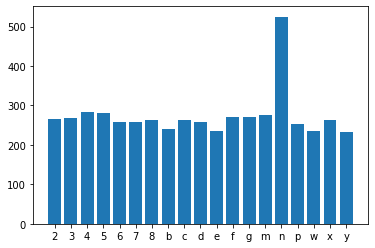

In [ ]:
import matplotlib.pyplot as plt

# 라벨링
def char_to_num(num):
  if num in characters:
    return characters.index(num)
  return None

character_num = [0] * len(characters)

print(label.shape)
for i in range(len(label)):
  for j in range(len(label[0])):
    character_num[char_to_num(label[i,j])] += 1
print(character_num)

x = np.arange(len(characters))
plt.bar(x, character_num)
plt.xticks(x, characters)

plt.show()

In [ ]:
# 원핫인코딩    
num_label = np.empty((5, len_data, len(characters)), dtype = int)
for i in range(len_data):
  targs = np.zeros((5, len(characters)))
  for j, l in enumerate(label[i]):
    ind = char_to_num(l)
    targs[j, ind] = 1
    num_label[:, i] = targs

print(num_label[3][3])

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


In [ ]:
import random

index_list = np.arange(len_data)
random.shuffle(index_list)
print(index_list)

ntrain = int(len(label)*0.85)

# train, test split by random index
for i in range(len_data):
  train_X_data, test_X = images[index_list[:ntrain]], images[index_list[ntrain:]]
  train_y_data, test_y = num_label[:,index_list[:ntrain]], num_label[:,index_list[ntrain:]]

print(len(train_X_data),len(test_X))
print(train_X_data.shape)
print(len(train_y_data[0]),len(test_y[0]))
print(train_y_data[3])

[356 815 826 ... 258   0 469]
884 156
(884, 50, 200, 1)
884 156
[[0 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(5, 3536, 19)
(884, 19)


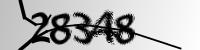

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]


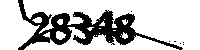

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]


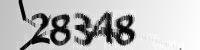

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]


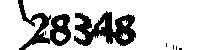

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]


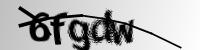

[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]


In [ ]:
from google.colab.patches import cv2_imshow
from PIL import Image

# 이미지 크기, 채널
train_X = np.zeros((len(train_X_data)*4, data_height, data_width, n_channel))
train_y = np.empty((5, len(train_y_data[0])*4, len(characters)), dtype = int)
print(train_y.shape)
print(train_y_data[0].shape)

# 이미지 전처리와 글자 파싱
for n in range(len(train_X_data)):
  image = np.array(train_X_data[n] * 255, 'uint8')
  image = data_augmentation(image)
  train_X[4*n:4*n+4, :, :, :] = image
  for i in range(5):
    train_y[i, 4*n] = train_y_data[i, n]
    train_y[i, 4*n+1] = train_y_data[i, n]
    train_y[i, 4*n+2] = train_y_data[i, n]
    train_y[i, 4*n+3] = train_y_data[i, n]

cv2_imshow(train_X[4] * 255)
print(train_y[:, 4])
cv2_imshow(train_X[5] * 255)
print(train_y[:, 5])
cv2_imshow(train_X[6] * 255)
print(train_y[:, 6])
cv2_imshow(train_X[7] * 255)
print(train_y[:, 7])
cv2_imshow(train_X[8] * 255)
print(train_y[:, 8])

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras import layers

In [ ]:
class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides=1,activation="relu",**kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [
        keras.layers.Conv2D(filters,3,strides=strides,
                            padding="same",use_bias=False),
        keras.layers.BatchNormalization(),
        self.activation,
        keras.layers.Conv2D(filters,3,strides=1,
                            padding="same",use_bias=False),
        keras.layers.BatchNormalization()
    ]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [
        keras.layers.Conv2D(filters,1,strides=strides,
                            padding="same",use_bias=False),
        keras.layers.BatchNormalization()
      ]
  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)


In [ ]:
def build_model(num_classes):
    img = layers.Input(shape=(50, 200, 1))
    conv1 = layers.Conv2D(64, (7, 7), padding='same',activation="relu")(img)
    mp1 = layers.MaxPool2D(2)(conv1)
    conv2 = layers.Conv2D(128, (3, 3), padding='same',activation="relu")(mp1)
    conv3 = layers.Conv2D(128, (3, 3), padding='same',activation="relu")(conv2)
    mp2 = layers.MaxPool2D(2)(conv3)
    conv4 = layers.Conv2D(128, (3, 3), padding='same',activation="relu")(mp2)
    conv5 = layers.Conv2D(128, (3, 3), padding='same',activation="relu")(conv4)
    mp3 = layers.MaxPool2D(2)(conv5)
    flat = layers.Flatten()(mp3)
      
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(128,activation='relu')(flat)
        drop1 = layers.Dropout(0.5)(dens1)
        dens2 = layers.Dense(64,activation='relu')(drop1)
        drop2 = layers.Dropout(0.5)(dens2)
        res = layers.Dense(num_classes, activation='softmax')(drop2)
        outs.append(res)
    
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=["accuracy"])
    return model

In [ ]:
num_classes = len(characters)
model = build_model(num_classes)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 50, 200, 64)  3200        ['input_8[0][0]']                
                                                                                                  
 max_pooling2d_21 (MaxPooling2D  (None, 25, 100, 64)  0          ['conv2d_35[0][0]']              
 )                                                                                                
                                                                                            

In [ ]:
# model.fit(train_X, [train_y[0],train_y[1],train_y[2],train_y[3],train_y[4]], epochs=10, batch_size=200, verbose=2,validation_split=0.2)
hist = model.fit(train_X, [train_y[0], train_y[1], train_y[2], train_y[3], train_y[4]], batch_size=64, epochs=100,verbose=1, validation_split=0.2)

Epoch 1/100
45/45 [==============================] - 7s 99ms/step - loss: 14.7243 - dense_107_loss: 2.9466 - dense_110_loss: 2.9473 - dense_113_loss: 2.9462 - dense_116_loss: 2.9427 - dense_119_loss: 2.9416 - dense_107_accuracy: 0.0725 - dense_110_accuracy: 0.0682 - dense_113_accuracy: 0.0661 - dense_116_accuracy: 0.0796 - dense_119_accuracy: 0.1036 - val_loss: 14.6942 - val_dense_107_loss: 2.9468 - val_dense_110_loss: 2.9382 - val_dense_113_loss: 2.9408 - val_dense_116_loss: 2.9325 - val_dense_119_loss: 2.9358 - val_dense_107_accuracy: 0.0734 - val_dense_110_accuracy: 0.1073 - val_dense_113_accuracy: 0.1017 - val_dense_116_accuracy: 0.1017 - val_dense_119_accuracy: 0.1073
Epoch 2/100
45/45 [==============================] - 4s 79ms/step - loss: 14.6526 - dense_107_loss: 2.9339 - dense_110_loss: 2.9359 - dense_113_loss: 2.9338 - dense_116_loss: 2.9323 - dense_119_loss: 2.9168 - dense_107_accuracy: 0.0810 - dense_110_accuracy: 0.0863 - dense_113_accuracy: 0.0753 - dense_116_accuracy: 0.

In [ ]:
hist.history

{'loss': [14.724285125732422,
  14.652642250061035,
  14.628769874572754,
  14.620702743530273,
  14.604190826416016,
  14.607548713684082,
  14.601645469665527,
  14.591910362243652,
  14.262430191040039,
  12.800127983093262,
  10.408544540405273,
  7.514711380004883,
  5.601968288421631,
  4.348526954650879,
  3.549954891204834,
  3.1311018466949463,
  2.6620161533355713,
  2.474207878112793,
  2.238809823989868,
  1.9223836660385132,
  1.840857982635498,
  1.72811758518219,
  1.7220335006713867,
  1.5520459413528442,
  1.5096193552017212,
  1.4191473722457886,
  1.3252043724060059,
  1.2599059343338013,
  1.2543145418167114,
  1.1374726295471191,
  1.1231956481933594,
  1.062882661819458,
  1.0042904615402222,
  1.014082908630371,
  0.951364278793335,
  0.9619724154472351,
  0.9071312546730042,
  0.9217386245727539,
  0.9735096096992493,
  0.8853057026863098,
  0.84806227684021,
  0.8348128795623779,
  0.7599650621414185,
  0.7898757457733154,
  0.7573760151863098,
  0.771104097366

In [ ]:
print("Train data accuracy")
print("dense 1:",hist.history["dense_107_accuracy"][99])
print("dense 2:",hist.history["dense_110_accuracy"][99])
print("dense 3:",hist.history["dense_113_accuracy"][99])
print("dense 4:",hist.history["dense_116_accuracy"][99])
print("dense 5:",hist.history["dense_119_accuracy"][99])

print("\nValidation data accuracy")
print("dense 1:",hist.history["val_dense_107_accuracy"][99])
print("dense 2:",hist.history["val_dense_110_accuracy"][99])
print("dense 3:",hist.history["val_dense_113_accuracy"][99])
print("dense 4:",hist.history["val_dense_116_accuracy"][99])
print("dense 5:",hist.history["val_dense_119_accuracy"][99])

Train data accuracy
dense 1: 0.9756011366844177
dense 2: 0.9731258749961853
dense 3: 0.9720650911331177
dense 4: 0.9717114567756653
dense 5: 0.9632248878479004

Validation data accuracy
dense 1: 0.9745762944221497
dense 2: 0.9774011373519897
dense 3: 0.9632768630981445
dense 4: 0.8841807842254639
dense 5: 0.9463276863098145


0.07248938828706741 0.06824611127376556 0.06612446904182434 0.07956152409315109 0.10360679030418396
100
0.07344632595777512 0.10734463483095169 0.10169491171836853 0.10169491171836853 0.10734463483095169
100
0.09830508381128311


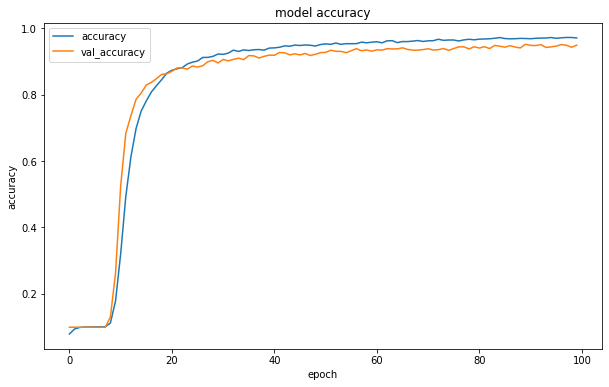

In [ ]:
import matplotlib.pyplot as plt
n_epoch = 100
acc = np.zeros((5, n_epoch))
val_acc = np.zeros((5, n_epoch))
accuracy = []
val_accuracy = []
acc[0, :] = hist.history['dense_107_accuracy']
acc[1, :] = hist.history['dense_110_accuracy']
acc[2, :] = hist.history['dense_113_accuracy']
acc[3, :] = hist.history['dense_116_accuracy']
acc[4, :] = hist.history['dense_119_accuracy']
print(acc[0, 0], acc[1, 0], acc[2, 0], acc[3, 0], acc[4, 0])
for i in range(n_epoch):
  ave = (acc[0, i] + acc[1, i] + acc[2, i] + acc[3, i] + acc[4, i]) / 5
  accuracy.append(ave)
print(len(accuracy))

val_acc[0, :] = hist.history['val_dense_107_accuracy']
val_acc[1, :] = hist.history['val_dense_110_accuracy']
val_acc[2, :] = hist.history['val_dense_113_accuracy']
val_acc[3, :] = hist.history['val_dense_116_accuracy']
val_acc[4, :] = hist.history['val_dense_119_accuracy']
print(val_acc[0, 0], val_acc[1, 0], val_acc[2, 0], val_acc[3, 0], val_acc[4, 0])
for i in range(n_epoch):
  ave = (val_acc[0, i] + val_acc[1, i] + val_acc[2, i] + val_acc[3, i] + val_acc[4, i]) / 5
  val_accuracy.append(ave)
print(len(val_accuracy))
print(val_accuracy[0])

plt.figure(figsize=(10, 6))
plt.plot(accuracy, label='training accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc = 'upper left')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
     

2.946550130844116 2.947305917739868 2.9461686611175537 2.942657709121704 2.9416019916534424
100
2.944856882095337
2.946820020675659 2.9381778240203857 2.94083833694458 2.9325437545776367 2.9357824325561523
100
2.938832473754883


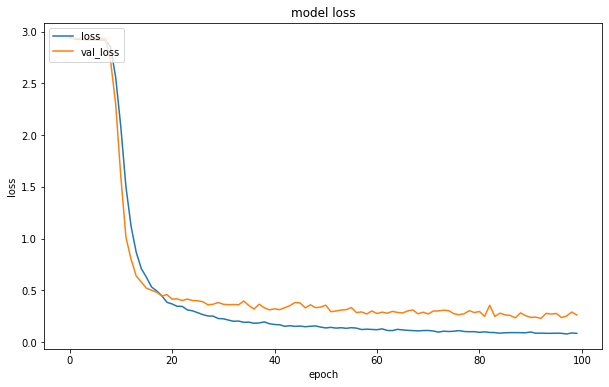

In [ ]:
loss = np.zeros((5, n_epoch))
val_loss = np.zeros((5, n_epoch))
loss_ave = []
val_loss_ave = []
loss[0, :] = hist.history['dense_107_loss']
loss[1, :] = hist.history['dense_110_loss']
loss[2, :] = hist.history['dense_113_loss']
loss[3, :] = hist.history['dense_116_loss']
loss[4, :] = hist.history['dense_119_loss']
print(loss[0, 0], loss[1, 0], loss[2, 0], loss[3, 0], loss[4, 0])
for i in range(n_epoch):
  ave = (loss[0, i] + loss[1, i] + loss[2, i] + loss[3, i] + loss[4, i]) / 5
  loss_ave.append(ave)
print(len(loss_ave))
print(loss_ave[0])

val_loss[0, :] = hist.history['val_dense_107_loss']
val_loss[1, :] = hist.history['val_dense_110_loss']
val_loss[2, :] = hist.history['val_dense_113_loss']
val_loss[3, :] = hist.history['val_dense_116_loss']
val_loss[4, :] = hist.history['val_dense_119_loss']
print(val_loss[0, 0], val_loss[1, 0], val_loss[2, 0], val_loss[3, 0], val_loss[4, 0])
for i in range(n_epoch):
  ave = (val_loss[0, i] + val_loss[1, i] + val_loss[2, i] + val_loss[3, i] + val_loss[4, i]) / 5
  val_loss_ave.append(ave)
print(len(val_loss_ave))
print(val_loss_ave[0])

plt.figure(figsize=(10, 6))
plt.plot(loss_ave, label='training loss')
plt.plot(val_loss_ave, label='validation loss')
plt.legend(['loss', 'val_loss'], loc = 'upper left')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
def predict_x(img):
    img = np.reshape(img, (1, 50, 200, 1))
    res = np.array(model.predict(img))
    ans = np.reshape(res, (5, num_classes))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += characters[l]
    return capt#, sum(probs) / 5

In [ ]:
def print_y(y_list):
  result = ""
  for y in y_list:
    for i in range(len(y)):
      if int(y[i]) == 1:
        result += characters[i]
  return result

In [ ]:
print(predict_x(test_X[0]))
print(print_y([test_y[0][0], test_y[1][0], test_y[2][0], test_y[3][0], test_y[4][0]]))

1/1 [==============================] - 0s 17ms/step
bny4w
bny4w


In [ ]:
count = 0
for i in range(len(train_X)):
  if predict_x(train_X[i]) != print_y([train_y[0][i], train_y[1][i], train_y[2][i], train_y[3][i], train_y[4][i]]):
    count += 1

print((len(train_X)-count)/len(train_X))
print(len(train_X))

1/1 [==============================] - 0s 19ms/step
0.9589932126696833
3536


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
count = 0
y_pred = []
y_true = []
index = []

for i in range(len(train_X)):
  predict = predict_x(train_X[i])
  result = print_y([train_y[0][i], train_y[1][i], train_y[2][i], train_y[3][i], train_y[4][i]])
  for j in range(len(predict)):
    y_pred.append(predict[j])
    y_true.append(result[j]) 

1/1 [==============================] - 0s 21ms/step


0.9898190045248869
0.9902133109441742
0.9902578832572736
0.9902133109441742
0.9902223407113654
(19, 19)


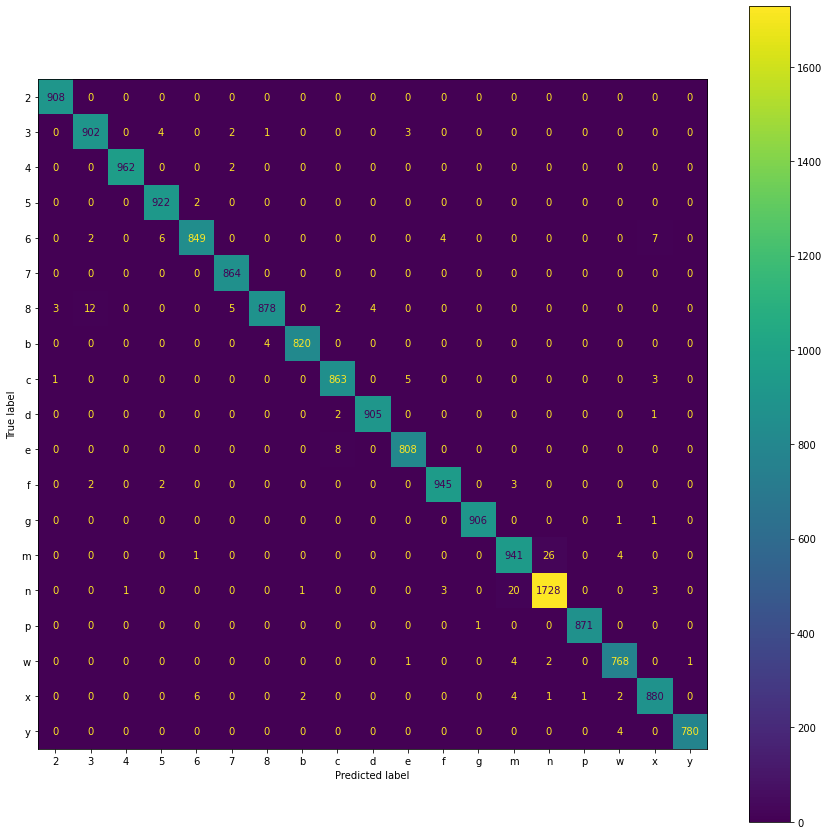

In [ ]:
print(metrics.accuracy_score(y_true, y_pred)) 
print(metrics.balanced_accuracy_score(y_true, y_pred)) 
print(metrics.precision_score(y_true, y_pred,average="macro"))
print(metrics.recall_score(y_true, y_pred,average="macro"))
print(metrics.f1_score(y_true, y_pred,average="macro")) 

conf_mat = metrics.confusion_matrix(y_true, y_pred) 
print(conf_mat.shape)
conf_dis = metrics.ConfusionMatrixDisplay(conf_mat, display_labels=characters)
fig, ax = plt.subplots(figsize=(15, 15))
conf_dis.plot(ax = ax)

In [ ]:
# p를 b로 misclassification한 경우
for i in range(len(index)):
  cv2_imshow(train_X[index[i]] * 255)

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
count = 0
y_pred.clear()
y_true.clear()
index.clear()

for i in range(len(test_X)):
  predict = predict_x(test_X[i])
  result = print_y([test_y[0][i], test_y[1][i], test_y[2][i], test_y[3][i], test_y[4][i]])
  for j in range(len(predict)):
    y_pred.append(predict[j])
    y_true.append(result[j]) 

1/1 [==============================] - 0s 14ms/step


0.9358974358974359
0.9359289600948673
0.9371251144335548
0.9359289600948673
0.9352833075195924
(19, 19)


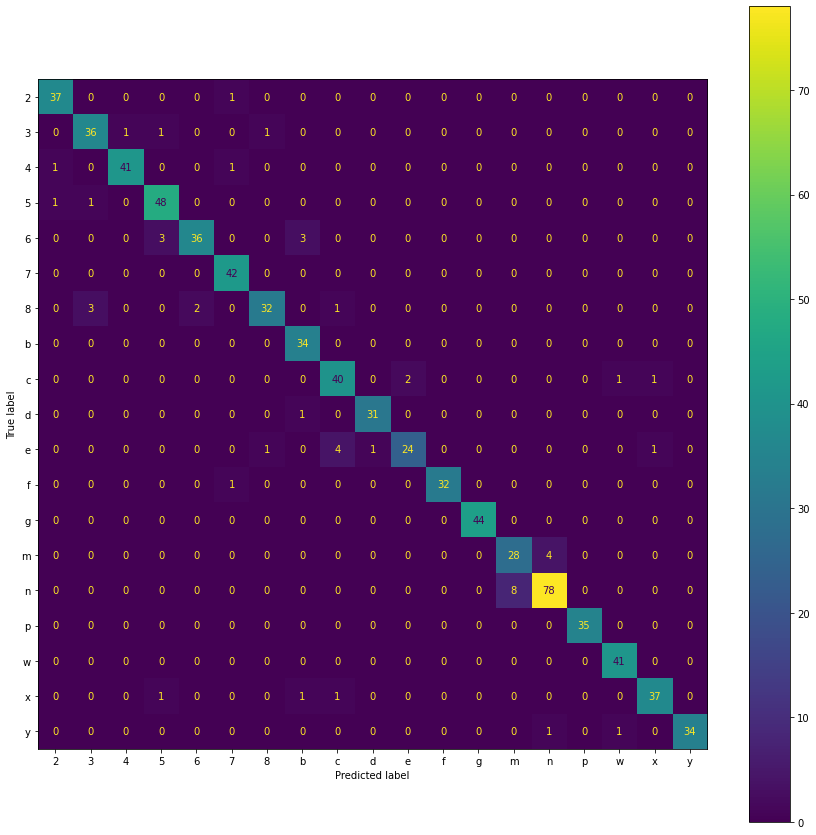

In [ ]:
print(metrics.accuracy_score(y_true, y_pred)) 
print(metrics.balanced_accuracy_score(y_true, y_pred)) 
print(metrics.precision_score(y_true, y_pred,average="macro"))
print(metrics.recall_score(y_true, y_pred,average="macro"))
print(metrics.f1_score(y_true, y_pred,average="macro")) 

conf_mat = metrics.confusion_matrix(y_true, y_pred) 
print(conf_mat.shape)
conf_dis = metrics.ConfusionMatrixDisplay(conf_mat, display_labels=characters)
fig, ax = plt.subplots(figsize=(15, 15))
conf_dis.plot(ax = ax)